In [1]:
from sklearn.manifold import MDS
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from concurrent import futures
from sklearn.neighbors import KNeighborsClassifier
import h5py

import dtw
import sys
sys.path.append('../')
import util

## DTW

We use [Dynamic Time Warping](https://masterwangzx.com/2019/02/06/dtw/) to calculate the distance of each sample. It takes a lot of time.

In [3]:
# number of good sample, this must bigger than 50. The bigger the more time cost.
num = 50

data, num_good, num_bad = util.load_train_data(num)
dist = np.zeros((len(data), len(data)))


def get_dist(data, index1, index2):
    distance, cost, path = dtw.dtw(data[index1], data[index2])
    print('complete ({d1},{d2})'.format(d1=index1, d2=index2))
    return distance, index1, index2


process = [(i, j) for i in range(len(data)) for j in range(i + 1, len(data))]

with futures.ProcessPoolExecutor(max_workers=8) as executor:
    futures = [executor.submit(get_dist, data, item[0], item[1]) for item in process]
    for future in futures:
        distance, index1, index2 = future.result()
        dist[index1, index2] = distance

for i in range(len(data)):
    for j in range(0, i):
        dist[i, j] = dist[j, i]


complete (0,1)
complete (0,2)
complete (0,5)
complete (0,3)
complete (0,4)
complete (0,7)
complete (0,6)
complete (0,8)
complete (0,9)
complete (0,11)
complete (0,10)
complete (0,13)
complete (0,12)
complete (0,15)
complete (0,16)
complete (0,14)
complete (0,17)
complete (0,18)
complete (0,21)
complete (0,19)
complete (0,24)
complete (0,22)
complete (0,20)
complete (0,23)
complete (0,26)
complete (0,28)
complete (0,25)
complete (0,27)
complete (0,30)
complete (0,29)
complete (0,31)
complete (0,32)
complete (0,33)
complete (0,34)
complete (0,35)
complete (0,36)
complete (0,37)
complete (0,40)
complete (0,38)
complete (0,39)
complete (0,41)
complete (0,42)
complete (0,43)
complete (0,46)
complete (0,44)
complete (0,47)
complete (0,45)
complete (0,48)
complete (0,49)
complete (0,50)
complete (0,54)
complete (0,51)
complete (0,52)
complete (0,53)
complete (0,55)
complete (0,56)
complete (0,57)
complete (0,58)
complete (0,62)
complete (0,61)
complete (0,64)
complete (0,63)
complete (0,60)
c

complete (5,41)
complete (5,42)
complete (5,43)
complete (5,44)
complete (5,45)
complete (5,46)
complete (5,48)
complete (5,47)
complete (5,49)
complete (5,50)
complete (5,51)
complete (5,52)
complete (5,54)
complete (5,55)
complete (5,56)
complete (5,53)
complete (5,57)
complete (5,58)
complete (5,59)
complete (5,60)
complete (5,61)
complete (5,64)
complete (5,62)
complete (5,63)
complete (5,65)
complete (5,68)
complete (5,66)
complete (5,67)
complete (5,69)
complete (5,70)
complete (5,71)
complete (5,73)
complete (5,72)
complete (5,74)
complete (5,75)
complete (5,77)
complete (5,76)
complete (5,78)
complete (5,80)
complete (5,81)
complete (5,79)
complete (5,82)
complete (5,83)
complete (5,84)
complete (5,85)
complete (5,86)
complete (5,88)
complete (5,87)
complete (5,89)
complete (5,90)
complete (5,92)
complete (5,91)
complete (5,93)
complete (5,94)
complete (5,97)
complete (5,96)
complete (5,95)
complete (5,98)
complete (6,7)
complete (6,8)
complete (6,10)
complete (6,9)
complete (6

complete (11,14)
complete (11,15)
complete (11,13)
complete (11,17)
complete (11,16)
complete (10,98)
complete (11,12)
complete (11,18)
complete (11,19)
complete (11,21)
complete (11,20)
complete (11,23)
complete (11,22)
complete (11,24)
complete (11,25)
complete (11,26)
complete (11,27)
complete (11,28)
complete (11,29)
complete (11,32)
complete (11,31)
complete (11,30)
complete (11,33)
complete (11,34)
complete (11,36)
complete (11,38)
complete (11,35)
complete (11,40)
complete (11,39)
complete (11,41)
complete (11,37)
complete (11,42)
complete (11,43)
complete (11,47)
complete (11,44)
complete (11,45)
complete (11,46)
complete (11,48)
complete (11,49)
complete (11,50)
complete (11,51)
complete (11,52)
complete (11,55)
complete (11,53)
complete (11,54)
complete (11,56)
complete (11,57)
complete (11,58)
complete (11,60)
complete (11,62)
complete (11,61)
complete (11,59)
complete (11,64)
complete (11,65)
complete (11,63)
complete (11,66)
complete (11,68)
complete (11,69)
complete (11,7

complete (16,73)
complete (16,74)
complete (16,76)
complete (16,77)
complete (16,78)
complete (16,75)
complete (16,79)
complete (16,80)
complete (16,81)
complete (16,87)
complete (16,83)
complete (16,86)
complete (16,85)
complete (16,82)
complete (16,84)
complete (16,89)
complete (16,88)
complete (16,94)
complete (16,90)
complete (16,91)
complete (16,92)
complete (16,93)
complete (16,95)
complete (16,97)
complete (16,96)
complete (17,18)
complete (16,98)
complete (17,19)
complete (17,21)
complete (17,20)
complete (17,22)
complete (17,23)
complete (17,24)
complete (17,25)
complete (17,26)
complete (17,28)
complete (17,27)
complete (17,29)
complete (17,30)
complete (17,31)
complete (17,32)
complete (17,33)
complete (17,34)
complete (17,35)
complete (17,36)
complete (17,37)
complete (17,38)
complete (17,39)
complete (17,41)
complete (17,40)
complete (17,43)
complete (17,42)
complete (17,44)
complete (17,45)
complete (17,46)
complete (17,47)
complete (17,48)
complete (17,49)
complete (17,5

complete (22,87)
complete (22,86)
complete (22,85)
complete (22,83)
complete (22,88)
complete (22,89)
complete (22,90)
complete (22,92)
complete (22,94)
complete (22,96)
complete (22,91)
complete (22,93)
complete (22,95)
complete (22,97)
complete (22,98)
complete (23,25)
complete (23,24)
complete (23,28)
complete (23,26)
complete (23,27)
complete (23,29)
complete (23,30)
complete (23,31)
complete (23,32)
complete (23,34)
complete (23,33)
complete (23,36)
complete (23,35)
complete (23,37)
complete (23,39)
complete (23,38)
complete (23,40)
complete (23,41)
complete (23,42)
complete (23,44)
complete (23,45)
complete (23,43)
complete (23,47)
complete (23,46)
complete (23,48)
complete (23,49)
complete (23,54)
complete (23,50)
complete (23,51)
complete (23,53)
complete (23,55)
complete (23,52)
complete (23,56)
complete (23,57)
complete (23,58)
complete (23,60)
complete (23,62)
complete (23,59)
complete (23,61)
complete (23,64)
complete (23,63)
complete (23,65)
complete (23,66)
complete (23,6

complete (29,61)
complete (29,64)
complete (29,63)
complete (29,66)
complete (29,65)
complete (29,67)
complete (29,68)
complete (29,69)
complete (29,70)
complete (29,72)
complete (29,71)
complete (29,73)
complete (29,77)
complete (29,76)
complete (29,75)
complete (29,74)
complete (29,78)
complete (29,79)
complete (29,80)
complete (29,81)
complete (29,83)
complete (29,82)
complete (29,84)
complete (29,85)
complete (29,87)
complete (29,86)
complete (29,88)
complete (29,89)
complete (29,90)
complete (29,92)
complete (29,93)
complete (29,91)
complete (29,94)
complete (29,96)
complete (29,97)
complete (29,95)
complete (30,33)
complete (30,31)
complete (30,32)
complete (29,98)
complete (30,34)
complete (30,36)
complete (30,35)
complete (30,37)
complete (30,39)
complete (30,38)
complete (30,40)
complete (30,41)
complete (30,43)
complete (30,42)
complete (30,44)
complete (30,45)
complete (30,46)
complete (30,47)
complete (30,48)
complete (30,49)
complete (30,52)
complete (30,50)
complete (30,5

complete (36,88)
complete (36,90)
complete (36,92)
complete (36,93)
complete (36,91)
complete (36,94)
complete (36,96)
complete (36,97)
complete (36,95)
complete (36,98)
complete (37,40)
complete (37,39)
complete (37,41)
complete (37,38)
complete (37,42)
complete (37,43)
complete (37,44)
complete (37,47)
complete (37,45)
complete (37,46)
complete (37,48)
complete (37,50)
complete (37,49)
complete (37,51)
complete (37,52)
complete (37,54)
complete (37,53)
complete (37,55)
complete (37,56)
complete (37,57)
complete (37,58)
complete (37,60)
complete (37,59)
complete (37,62)
complete (37,61)
complete (37,63)
complete (37,64)
complete (37,65)
complete (37,68)
complete (37,67)
complete (37,69)
complete (37,66)
complete (37,70)
complete (37,72)
complete (37,71)
complete (37,73)
complete (37,76)
complete (37,74)
complete (37,77)
complete (37,75)
complete (37,78)
complete (37,79)
complete (37,80)
complete (37,81)
complete (37,83)
complete (37,85)
complete (37,82)
complete (37,84)
complete (37,8

complete (45,58)
complete (45,60)
complete (45,59)
complete (45,62)
complete (45,63)
complete (45,64)
complete (45,61)
complete (45,65)
complete (45,66)
complete (45,67)
complete (45,68)
complete (45,69)
complete (45,71)
complete (45,70)
complete (45,72)
complete (45,73)
complete (45,74)
complete (45,77)
complete (45,75)
complete (45,76)
complete (45,78)
complete (45,79)
complete (45,80)
complete (45,81)
complete (45,82)
complete (45,83)
complete (45,85)
complete (45,84)
complete (45,86)
complete (45,87)
complete (45,88)
complete (45,89)
complete (45,90)
complete (45,92)
complete (45,91)
complete (45,93)
complete (45,96)
complete (45,94)
complete (45,95)
complete (45,97)
complete (45,98)
complete (46,47)
complete (46,48)
complete (46,50)
complete (46,51)
complete (46,49)
complete (46,52)
complete (46,54)
complete (46,53)
complete (46,55)
complete (46,56)
complete (46,57)
complete (46,58)
complete (46,59)
complete (46,60)
complete (46,61)
complete (46,62)
complete (46,63)
complete (46,6

complete (55,65)
complete (55,66)
complete (55,69)
complete (55,68)
complete (55,70)
complete (55,67)
complete (55,72)
complete (55,71)
complete (55,74)
complete (55,73)
complete (55,75)
complete (55,77)
complete (55,76)
complete (55,78)
complete (55,79)
complete (55,80)
complete (55,81)
complete (55,85)
complete (55,84)
complete (55,82)
complete (55,86)
complete (55,83)
complete (55,87)
complete (55,89)
complete (55,88)
complete (55,92)
complete (55,90)
complete (55,94)
complete (55,93)
complete (55,91)
complete (55,95)
complete (55,96)
complete (55,97)
complete (55,98)
complete (56,57)
complete (56,58)
complete (56,60)
complete (56,59)
complete (56,62)
complete (56,61)
complete (56,64)
complete (56,63)
complete (56,65)
complete (56,68)
complete (56,66)
complete (56,67)
complete (56,69)
complete (56,70)
complete (56,72)
complete (56,71)
complete (56,73)
complete (56,74)
complete (56,75)
complete (56,76)
complete (56,78)
complete (56,77)
complete (56,79)
complete (56,80)
complete (56,8

complete (68,81)
complete (68,80)
complete (68,79)
complete (68,82)
complete (68,83)
complete (68,84)
complete (68,85)
complete (68,87)
complete (68,86)
complete (68,88)
complete (68,89)
complete (68,90)
complete (68,92)
complete (68,91)
complete (68,94)
complete (68,93)
complete (68,95)
complete (68,97)
complete (68,96)
complete (68,98)
complete (69,71)
complete (69,70)
complete (69,72)
complete (69,74)
complete (69,73)
complete (69,76)
complete (69,75)
complete (69,77)
complete (69,78)
complete (69,79)
complete (69,80)
complete (69,81)
complete (69,83)
complete (69,85)
complete (69,82)
complete (69,84)
complete (69,86)
complete (69,87)
complete (69,88)
complete (69,89)
complete (69,93)
complete (69,90)
complete (69,94)
complete (69,92)
complete (69,91)
complete (69,95)
complete (69,96)
complete (69,97)
complete (70,71)
complete (69,98)
complete (70,72)
complete (70,74)
complete (70,73)
complete (70,76)
complete (70,77)
complete (70,75)
complete (70,78)
complete (70,81)
complete (70,7

Now we can use MDS to visualize what we calculate.

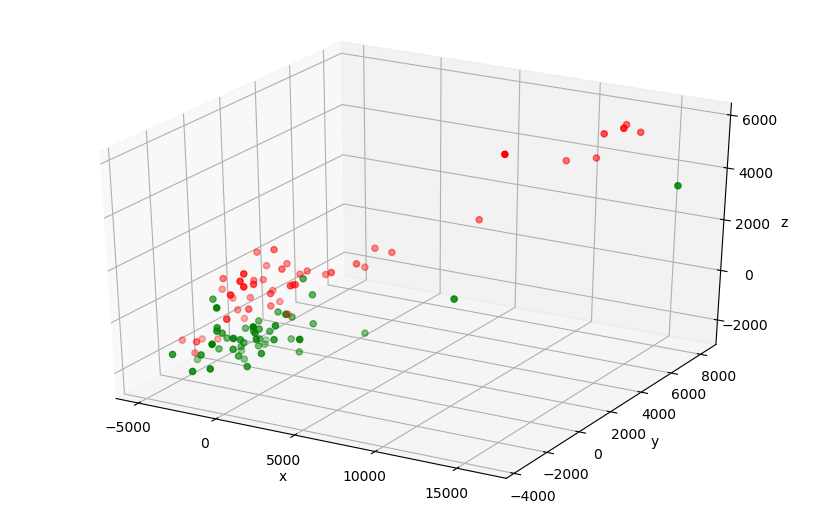

<Figure size 432x288 with 0 Axes>

In [4]:
mds = MDS(n_components=3, dissimilarity="precomputed")
pos = mds.fit_transform(dist)

fig = plt.figure(figsize=(8, 5), dpi= 100)
ax = Axes3D(fig)
ax.scatter(pos[:num, 0], pos[:num, 1], pos[:num, 2], c='g')
ax.scatter(pos[num:, 0], pos[num:, 1], pos[num:, 2], c='r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

Use KNN to see how is DTW performing.

In [6]:
# prepare data
labels = np.array([1]*(len(pos)-50)+[0]*50,dtype=np.int)
train_x = pos[10:-10, :]
train_y = labels[10:-10]
test_x = np.vstack((pos[:10, :], pos[-10:, :]))
test_y = np.hstack((labels[:10], labels[-10:]))

# KNN
neigh = KNeighborsClassifier(n_neighbors=5, weights='distance')
neigh.fit(train_x, train_y)
neigh.score(test_x, test_y)

0.95